In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import random
import pandas as pd
import numpy as np
import pickle
from classes import StackedImages, ImageProcessor
from IPython.display import clear_output


from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten



from collections import deque

import timeit
import time

from skimage import io
import skimage
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#data_input = '/users/momori/data/stacked_images.pkl'

#get the game files 
import os
import sys
sys.path.append("/Users/momori/Documents/GitHub/Data-Science/\
Springboard/Capstone Project 2/resources/Keras-FlappyBird-master")
sys.path.append("/Users/momori/Documents/GitHub/Data-Science/\
Springboard/Capstone Project 2/resources/Keras-FlappyBird-master/game/")


import wrapped_flappy_bird as game


couldn't import doomish
Couldn't import doom


Using TensorFlow backend.


In [2]:
##disable graphics for cloud computing
os.putenv('SDL_VIDEODRIVER', 'fbcon')
os.environ["SDL_VIDEODRIVER"] = "dummy"

'''variables to init'''
num_frames_to_stack = 4
epsilon = 0.8 #when to choose best action vs random action
gamma = 0.8 #future reward discount factor

#get image dimensions
game_state = FlappyBird()
p = PLE(game_state, fps=30, display_screen=False)
p.init()
image = p.getScreenRGB()
input_num_rows = ImageProcessor(image).shape()[0]
input_num_cols = ImageProcessor(image).shape()[1]



In [4]:
# game_state = init_game()
# state, reward, is_terminal = game_state.frame_step([1,0])


In [46]:
def update_reward(value):
    #return value
    if value==0.0:
        return 0.1
    elif value==1.0:
        #print 'score!!'
        return 1.0
    elif value==-5:
        return -5.0
    elif value==-4.0: #crossed pipe and hit the pipe at the same time
        return -5.0
    else:
        print 'unknown reward', value
        return value

def value_to_action(value):
    if value == 119:
        pass
    elif value == None:
        pass
    else:
        print 'bad action'
        return None

class PolicyAgent(object):
    '''agent to learn and provide optimal actions during the game run.
    the output is the expected reward for taking that action in that state
    output:
        higher index 0 -> flap
        higher index 1 -> do nothing
        '''
    def __init__(self, input_num_rows, input_num_cols):
        ##cnn 
#         model = Sequential()
#         model.add(Conv2D(64, (8,8), activation='relu', input_shape=(input_num_rows, input_num_cols, 4)))
#         #model.add(Conv2D(64, (8,8), activation='sigmoid', input_shape=(batch_count,4, input_num_rows, input_num_cols)))

#         model.add(MaxPooling2D(pool_size=(10,10)))
#         model.add(Flatten())
#         model.add(Dense(10, activation='tanh'))
#         #model.add(Dense(2, activation='softmax'))
#         model.add(Dense(2, activation='tanh'))
#         #model.compile(loss='categorical_crossentropy', optimizer='sgd')
#         model.compile(loss='mse', optimizer='sgd')
        
    
    
    #bias_initializer='zeros')

        model = Sequential()
        model.add(Conv2D(32, 8, 8, subsample=(4, 4), border_mode='same',input_shape=(input_num_rows, input_num_cols, 4)))  #80*80*4
        model.add(Activation('relu'))
        model.add(Conv2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512,bias_initializer='zeros'))
        model.add(Activation('relu'))
        model.add(Dense(2, bias_initializer='zeros'))
        adam = Adam(lr=1e-4)
        model.compile(loss='mse',optimizer=adam) 

        self._model = model
        
        self._training_counter = 0
        
        #loss counter
        self._loss = 0
    
    
    def fit(self, stacked_images, y_data, batch_size=32, epochs=1):
        if type(stacked_images) is StackedImages:
            x_data = stacked_images.get_stacked_images()
        else:
            x_data = stacked_images
        #x_data = x_data.reshape(x_data.shape[1], x_data.shape[2], x_data.shape[0], 1)
        y_data = np.array(y_data)
        self._model.fit(x_data, y_data, batch_size, epochs, verbose=0)
        self._training_counter += 1
        
        
    def train_on_batch(self, x_data, y_data):
        #print 'training print'
        #print x_data.shape, y_data.shape
        if len(x_data) != len(y_data):
            print 'unequal lengths in data'
            return None
        shape_x = x_data[0].shape
        shape_y = y_data[0].shape
        for i in range(len(x_data)):
            #x_data[i] = x_data[i].reshape(shape_x[0], shape_x[1], shape_x[2], 1)
            y_data[i] = y_data[i].reshape(1,shape_y[0])
        inputs = np.concatenate(x_data, axis=0)
        targets = np.concatenate(y_data, axis=0)
        self._model.train_on_batch(inputs, targets)
        self._training_counter += inputs.shape[0]
        
    def predict(self, stacked_images):
        #print 'predict flag', stacked_images.shape
        #if type(stacked_images) is not StackedImages:
        #    print 'bad input type, found', type(stacked_images)
        if type(stacked_images) is StackedImages:
            x_data = stacked_images.get_stacked_images()
            #x_data = x_data.reshape(1, x_data.shape[1], x_data.shape[2], x_data.shape[0])
            output = self._model.predict(x_data)
        else:
            #print stacked_images.shape
            #x_data = stacked_images.reshape(1, stacked_images.shape[1], stacked_images.shape[2], stacked_images.shape[0])
            #x_data = stacked_images.reshape(1, stacked_images.shape[0], stacked_images.shape[1],stacked_images.shape[2])
            output = self._model.predict(stacked_images)
        #print 'predict', output
        index = np.random.choice(np.flatnonzero(output==np.max(output)))

        return index, output[0]
        
#         if index==0:
#             action = 119
#         else:
#             action = None
#         return action, output
    
    def save_weights(self, file_name):
        self._model.save_weights(file_name, overwrite=True)
        
    def get_loss(self):
        return self._loss
    
        
    def summary(self):
        return self._model.summary()
    
    def load_weights(self, file_name):
        self._model.load_weights(file_name)
        self._model.compile(loss='mse', optimizer='sgd')

        
class ReplayData(object):
    '''    replay_data: queue of lists
                 [0]: StackedImage object (current state)
                 [1]: Action
                 [2]: Reward
                 [3]: ImageProcessor object (next state)
                 [4]: is game terminal (boolean)'''
    def __init__(self, max_size=50):
        self._replay_data = deque()
        self._max_size = max_size
        
    @property 
    def max_size(self):
        return self._max_size
    
    @max_size.setter
    def max_size(self, value):
        self._max_size = value
    
    
    
    def append_smart(self, data, debug=False):
        self._replay_data.append(data)
        if debug:
            print 'debugging append_smart', self._max_size
        if len(self._replay_data) > self._max_size:
            self._replay_data.popleft()
        
    def size(self):
        return len(self._replay_data)
    
    def pop_left(self):
        return self._replay_data.popleft()
    
    def get_data(self):
        return self._replay_data
    
    def sample(self, count):
        return random.sample(self._replay_data, int(count))
        #self._replay_data = random.sample(self._replay_data, count)
        #return self
    
    def take_terminal_samples(self):
        return [i for i in self._replay_data if i[4]]
        #self._replay_data = [i for i in self._replay_data if i[4]]
        #return self
    
    def __getitem__(self, key):
        return self._replay_data[key]
    
    def __len__(self):
        return len(self._replay_data)

In [6]:
# rd = ReplayData(max_size=2)
# rd.append(1)
# print len(rd)
# rd.append(2)
# print len(rd)
# rd.append(3)
# print len(rd)
# rd.get_data()

In [7]:
# p = init_game()
# io.imshow(p.getScreenRGB())
# plt.show()

# for _ in range(100):
#     p.act(119)
#     io.imshow(p.getScreenRGB())
#     plt.show()

In [8]:
# total_reward, images = test_agent(agent)
# for i in images:
#     io.imshow(i)
#     plt.show()

In [57]:
# def init_game(display_screen=False):
#     '''initialize the game state'''
#     game = FlappyBird()
#     p = PLE(game, fps=30, display_screen=display_screen)
#     p.init()
#     #make first action since first frame is empty
#     p.act(None)
#     return p

def init_game(display_screen=False):
    '''initialize the game state'''
    game_state = game.GameState()
    s, reward, is_terminal = game_state.frame_step([1,0])
    return game_state

def test_agent(agent, debug=False, display_screen=False, display_image=False, direction=None):
    p = init_game(display_screen)
    max_frames = 100
    total_reward = 0
    
    observations = deque()
    
    
    all_stacked_images = []
    
    a_initial = np.zeros([2])
    a_initial[0] = 1
    x_t, reward, is_terminal = game_state.frame_step(a_initial)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t,(input_num_rows,input_num_cols))
    x_t = skimage.exposure.rescale_intensity(x_t, out_range=(0,255))
    state_t = np.stack((x_t,x_t,x_t,x_t), axis=2)
    state_t = state_t.reshape(1, state_t.shape[0], state_t.shape[1], state_t.shape[2])

    
    for i in range(max_frames):
        '''
        two phases exists, observing and training.
        up to num_to_observe frames, we push all data into experience replay queue,
        then once we have enough frames in the queue, we use batch training.
        '''
        #get suggested action
        action_t = np.zeros([2])
        action_index, output = agent.predict(state_t)
        action_t[action_index] = 1

        if debug:
            print action_index
        

        #get the state after action
        x_t1_c, reward_t, is_terminal = game_state.frame_step(action_t)
        
        if display_image:
            io.imshow(x_t1_c)
            plt.show()
        #reward = update_reward(.act(action))

        #new_state = p.getScreenRGB()
        x_t1 = skimage.color.rgb2gray(x_t1_c)
        x_t1 = skimage.transform.resize(x_t1,(input_num_rows,input_num_cols))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0,255))
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1)

        #drop one and add new state to the experience replay element
        state_t1 = np.append(x_t1, state_t[:,:,:,:3], axis=3)

        #store in replay queue. 
        #replay_data.append_smart((state_t, action, reward, state_t1, is_terminal))

        total_reward += reward_t
        
        state_t = state_t1
        
        all_stacked_images.append(x_t1_c)

        if is_terminal:
            print 'reached terminal state'
            break
    return total_reward, all_stacked_images





    print 'finished'

    
#     for i in range(max_frames):
#         #add most recent state to observations
#         observations.append(s_t)
#         #if we have enough observations, predict best action
#         if len(observations)%num_frames_to_stack == 0 and len(observations) > 0:
#             image_processors = [ImageProcessor(observations[index])\
#                                for index in range(num_frames_to_stack)]
#             stacked_images = StackedImages(image_processors, num_frames_to_stack)
#             all_stacked_images.append(stacked_images)
#             #get action from agent
#             if direction is None:
#                 action, output = agent.predict(stacked_images)
#             elif direction=='up':
#                 action = 119
#             else:
#                 action = None
#             reward = update_reward(p.act(action))
            
            
#             if display_image:
#                 io.imshow(p.getScreenRGB())
#                 plt.show()          
            
#             if debug:
#                 print action
            
#             if p.game_over():
#                 return total_reward, all_stacked_images
            
#             total_reward += reward
            
#             observations.popleft()
#     print 'did not reach terminal state in', max_frames, 'frames'
#     return total_reward, all_stacked_images
            
    
    
def train_policy(agent, replay_data, take_terminal = False, batch_count = 0, print_loss=False, epochs=1):
    '''use the replay data to train the network
    agent: PolicyAgent object
    replay_data: queue of lists
                 [0]: StackedImage object (current state)
                 [1]: Action
                 [2]: Reward
                 [3]: ImageProcessor object (next state)
                 [4]: is game terminal (boolean)
    take_terminal: train on only terminal samples
    batch_count: non-zero value indicates to use experience replay. 
                 # of frames to use from this replay_data to train the network
    '''

    if take_terminal:
        data_input = replay_data.take_terminal_samples()
        #data_input[0][0].plot()
    
    else:
        if batch_count!= 0:
            if batch_count < replay_data.size():
                data_input = replay_data.sample(batch_count)
    
#     if batch_count != 0 and !take_terminal:
#         if batch_count < replay_data.size():
#             replay_data = replay_data.sample(batch_count)
    
    inputs = []
    targets = []
    
    for i in range(len(data_input)):
        curr_state = data_input[i][0]#.get_stacked_images()
        action = data_input[i][1] ##action index
        reward = data_input[i][2]
        is_terminal = data_input[i][4]
        next_state = data_input[i][3]
#         print action
#         if action==119:
#             action = 0
#         else:
#             action = 1
        next_frame = data_input[i][3]
        
        
        #print 'here1'
        #io.imshow(next_frame.reshape(input_num_rows, input_num_cols))
        #plt.show()
        
        
        #next_state.append(next_frame)
        #next_state.pop(0)
        
        #predict on next state to find best action and reward
        #next_state = np.concatenate(next_state, axis=3)
        #print 'training stuff', type(next_state)
        _, output = agent.predict(next_state)
        next_reward = np.max(output)
      
        #images looks good
#         print 'here3'
#         for i in np.split(next_state, 4, axis=3):
#             io.imshow(i.reshape(96, 135))
#             plt.show()
        
        
        
        if is_terminal:
            total_reward = reward
        else: #update optimal action-selection policy
            total_reward = reward + gamma * next_reward

        output[action_index] = total_reward
        
        #target = np.zeros(2)
        #target[action] = total_reward
            
        inputs.append(curr_state)
        targets.append(output)
        
    
#     start_time1 = timeit.default_timer()
    loss = agent.train_on_batch(inputs, targets)
#     with open(output_file, 'a') as log_handle:
#         elapsed1 = timeit.default_timer() - start_time1
#         log_handle.write('trained network ' + str(elapsed1) + ' seconds\n')
    if print_loss:
        print 'loss is', loss, 'and agent_loss is', agent.get_loss()
        
    return agent#inputs, targets
        

In [48]:
# agent.predict()

In [49]:
def preprocess_state(state):
    state = skimage.color.rgb2gray(state)
    state = skimage.transform.resize(state,(input_num_rows,input_num_cols))
    state = skimage.exposure.rescale_intensity(state, out_range=(0,255))
    return state

In [50]:
# state = p.getScreenRGB()
# state = skimage.color.rgb2gray(state)
# state = skimage.transform.resize(state,(input_num_rows,input_num_cols))
# state = skimage.exposure.rescale_intensity(state, out_range=(0,255))

# state_t = np.stack((state,state,state,state), axis=2)
# state_t = state_t.reshape(1, state_t.shape[0], state_t.shape[1], state_t.shape[2])

# p.act(None)
# s_next = p.getScreenRGB()
# s_next = skimage.color.rgb2gray(s_next)
# s_next = skimage.transform.resize(s_next,(input_num_rows,input_num_cols))
# s_next = skimage.exposure.rescale_intensity(s_next, out_range=(0,255))
# s_next = s_next.reshape(1, s_next.shape[0], s_next.shape[1], 1)

# state_t1 = np.append(s_next, state_t[:,:,:,:3], axis=3)
# state_t1.shape

In [ ]:
#main program

#log files
output_file = 'logs/log'
reward_file = 'logs/rewards'
#clear files
open(output_file, 'w').close()
open(reward_file, 'w').close()

scores = []
scored_states = []

game_state = init_game()
max_frames = 50000#200#100000#2000000#500000#8000 ##first frame is null
exp_replay_size = 50000#10#max_frames*0.3#15000#50000#100#50000#100 #replay size > num to observe
num_to_observe = 3200#10#exp_replay_size*0.5#3200#50#3200#3200#1000#500#3200#50#int(max_frames * 0.2)#3200 #observations before we train the network
batch_count = 32#min(num_to_observe*0.1, 32)#32#25#32#75#32#int(num_to_observe * 0.1)  #train the model by selecting some subsample of the stored replays
                #contains lists of replay envs. each element is in the format
                #[state, action, reward, new_state, terminal(boolean)]
save_every = int(max_frames * 0.2) ##save the weights of the model every x frames
frames_per_action = 1 #only act on every x frames
max_score = 30  #stop the game when it reaches this many points
#save_every = 5000#int(max_frames * 0.3) ##save the weights of the model every x frames

start_time = timeit.default_timer()

count_game_over = 0

print 'training with batch_size:', batch_count

init_epsilon = 1.0#1.0
final_epsilon = 0.0001#0.1
epsilon = init_epsilon


observations = deque()
replay_data = ReplayData(max_size=exp_replay_size)
agent = PolicyAgent(input_num_rows, input_num_cols)

total_reward = 0

#print 'output of initial agent:'
#test_agent(agent, debug=True)



#get inital state state and make stacked object
a_initial = np.zeros([2])
a_initial[0] = 1
x_t, reward, is_terminal = game_state.frame_step(a_initial)

x_t = skimage.color.rgb2gray(x_t)
x_t = skimage.transform.resize(x_t,(input_num_rows,input_num_cols))
x_t = skimage.exposure.rescale_intensity(x_t, out_range=(0,255))
state_t = np.stack((x_t,x_t,x_t,x_t), axis=2)
state_t = state_t.reshape(1, state_t.shape[0], state_t.shape[1], state_t.shape[2])


for i in range(max_frames):
    '''
    two phases exists, observing and training.
    up to num_to_observe frames, we push all data into experience replay queue,
    then once we have enough frames in the queue, we use batch training.
    '''
    action_t = np.zeros([2])
    
    if i > num_to_observe and epsilon > final_epsilon: #decrease epsilon after finish observing
        epsilon -= (init_epsilon - final_epsilon)/max_frames #check on simulated annealing
        
        
    #print out how long each x frames took
    if i % (max_frames/10) == 0:
        elapsed = timeit.default_timer() - start_time
        with open(output_file, 'a') as log_handle:
            log_handle.write('done with ' + str(i) + ' frames with ' + str(elapsed) + ' seconds\n')
        start_time = timeit.default_timer() 
        
    #save model weights every x iterations
    if i % save_every == 0 and i != 0:
        f_name = 'model_weights_'+str(i)
        agent.save_weights(f_name)
        #print 'trained on', agent._training_counter
        
    if i == max_frames-1:
        f_name = 'model_weights_'+str(i)
        agent.save_weights(f_name)
        
     
    #choose action
    if random.random() < epsilon:
        action_index = random.randrange(2)
        #action = np.random.choice([119, None])
        action_t[action_index] = 1
    else:
        action_index, output = agent.predict(state_t)
        action_t[action_index] = 1
        
    #get the state after action
    x_t1_c, reward_t, is_terminal = game_state.frame_step(action_t)
    #reward = update_reward(.act(action))
    
    #new_state = p.getScreenRGB()
    x_t1 = skimage.color.rgb2gray(x_t1_c)
    x_t1 = skimage.transform.resize(x_t1,(input_num_rows,input_num_cols))
    x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0,255))
    x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1)
    
    #drop one and add new state to the experience replay element
    state_t1 = np.append(x_t1, state_t[:,:,:,:3], axis=3)
    
    #store in replay queue. 
    replay_data.append_smart((state_t, action_index, reward, state_t1, is_terminal))
    
    total_reward += reward
    
    #train once we have enough data
    if i > num_to_observe:
        train_policy(agent, replay_data, batch_count=batch_count)
        
    state_t = state_t1 
    
    if is_terminal:
        #all_obs.append(total_reward)
        #with open(reward_file, 'a') as f_handle:
        #    f_handle.write(str(total_reward)+',\n')
        total_reward = 0
        game_state = init_game()
        
        
   
        

print 'finished'

training with batch_size: 32


In [44]:
replay_data[0][0].shape
_, out = agent.predict(replay_data[0][0])
out

array([[-28.60390282, -22.83466148]], dtype=float32)

In [58]:
agent._training_counter

489

1


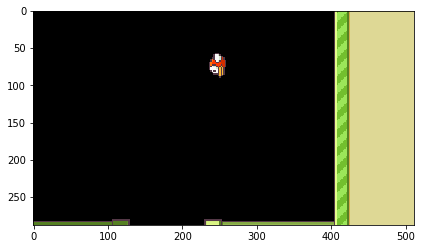

0


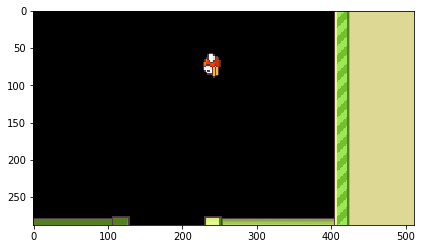

0


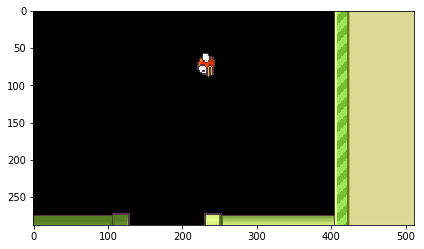

0


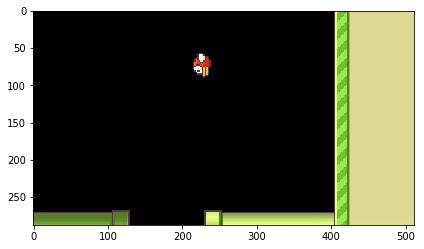

0


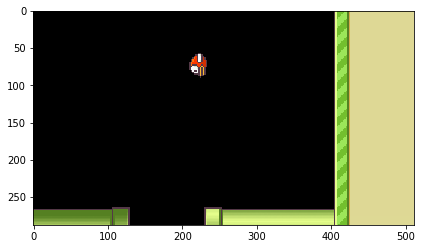

0


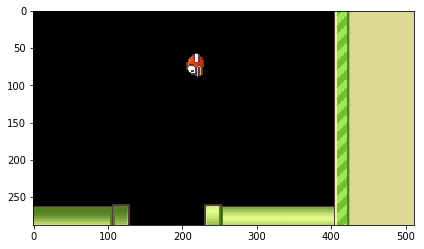

0


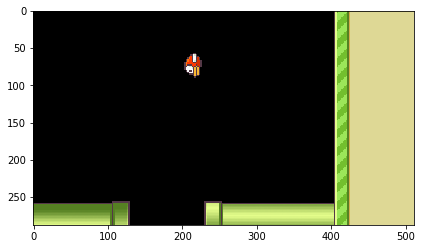

0


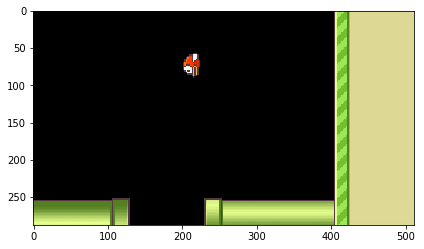

1


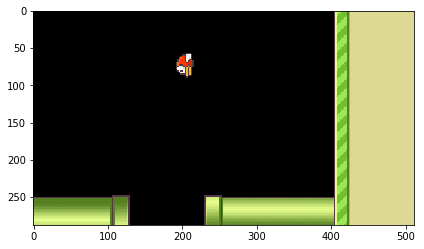

0


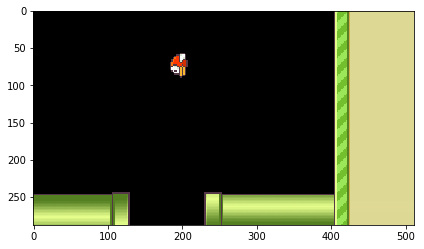

0


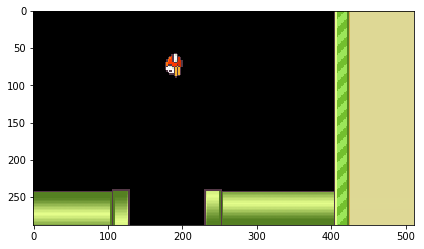

0


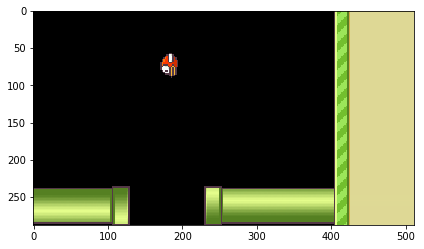

1


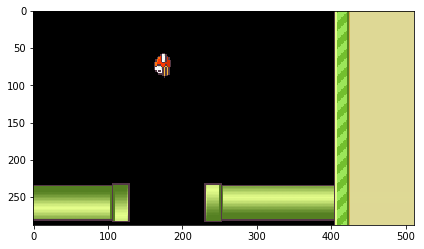

0


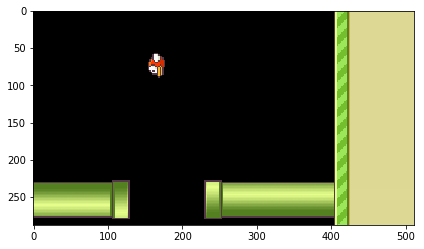

0


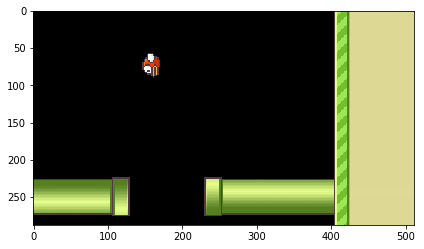

0


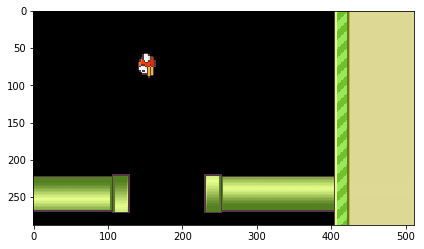

1


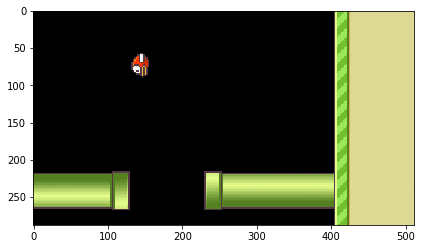

0


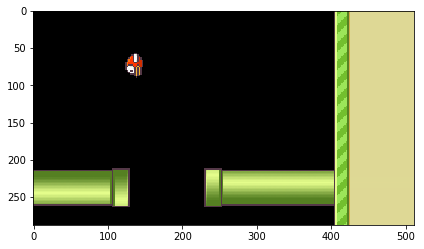

0


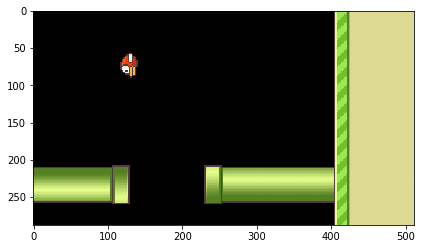

0


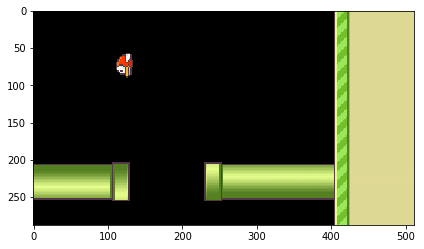

0


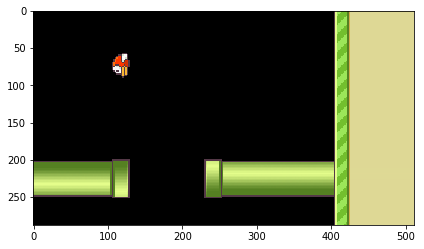

1


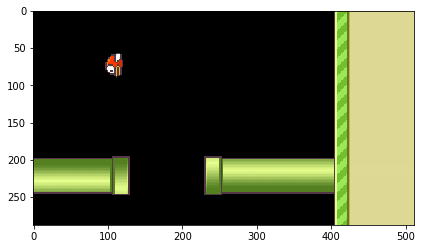

1


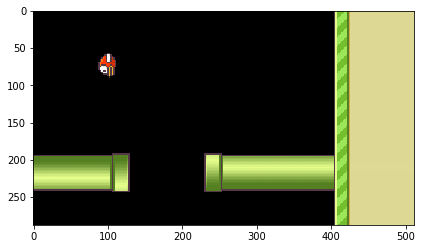

1


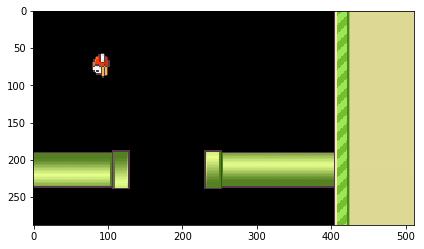

1


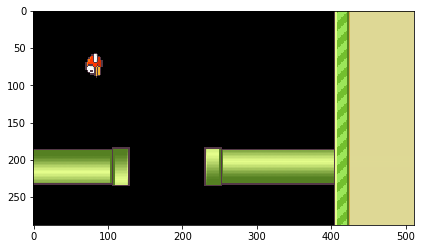

1


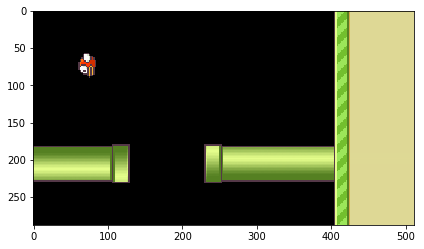

1


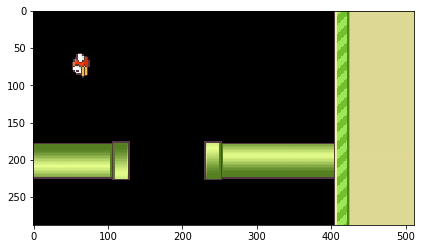

0


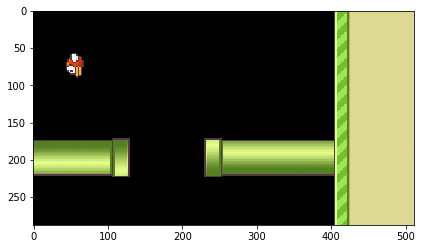

0


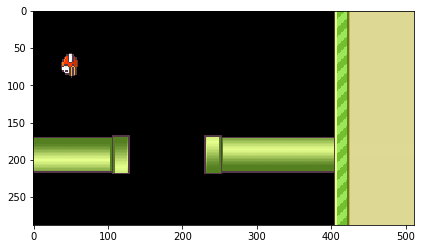

0


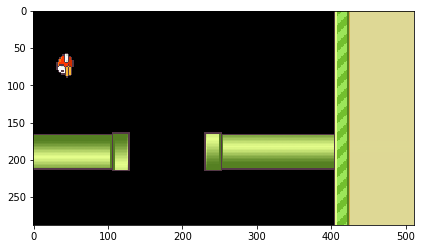

0


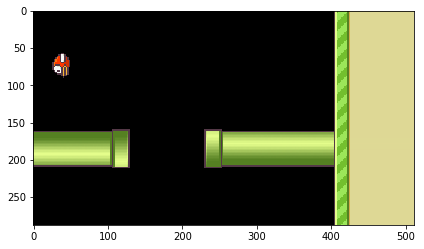

0


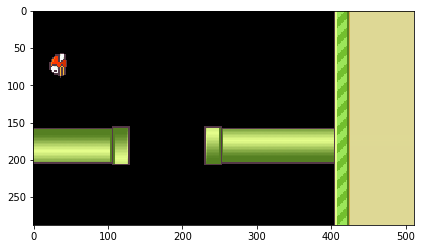

1


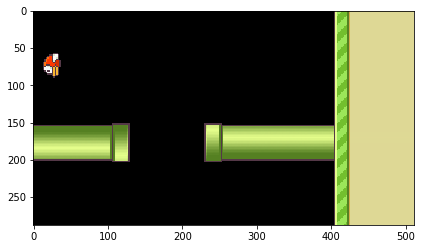

0


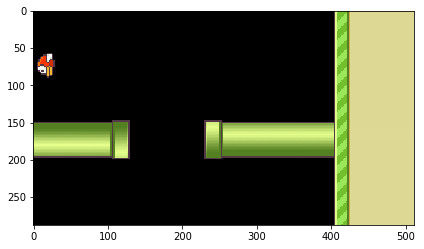

0


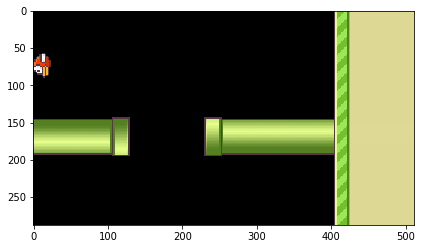

0


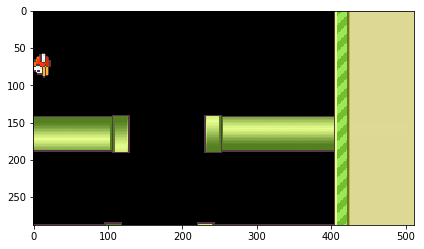

1


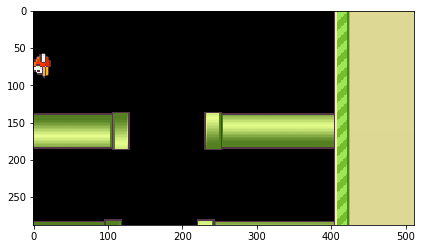

1


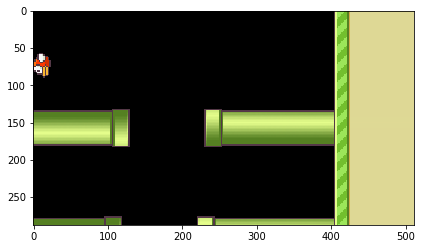

1


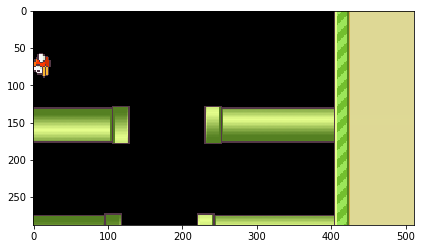

1


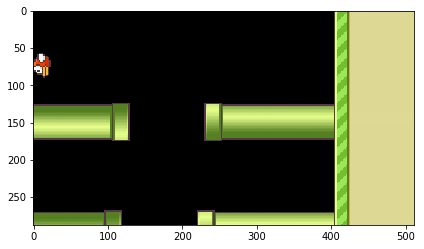

1


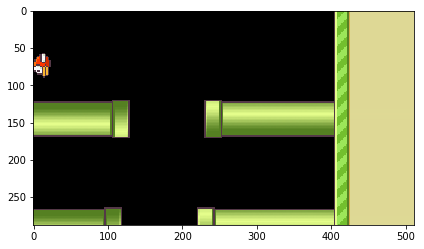

1


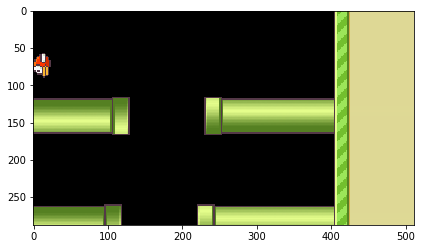

1


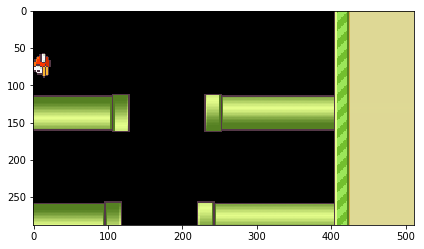

1


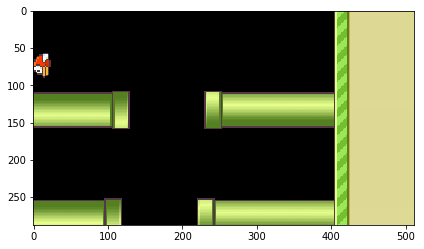

1


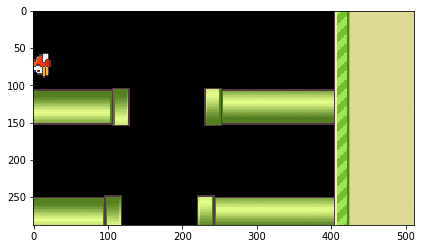

1


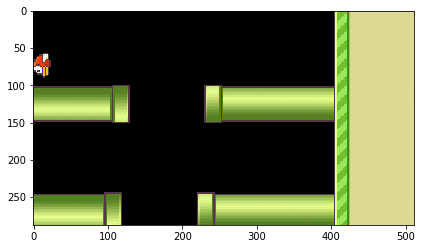

1


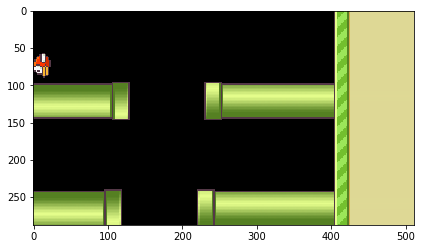

1


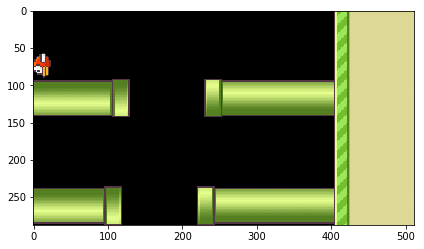

1


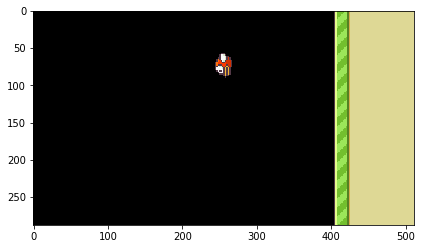

reached terminal state


In [60]:
tot_rewards, all_images = test_agent(agent, debug=True, display_image=True)

In [29]:
all_images[-1].shape

(288, 512, 3)

In [23]:
agent.predict(all_images[-1].get_stacked_images())

(119, array([[ 0.00640277, -0.09128989]], dtype=float32))

In [14]:
# test_agent(agent, debug=True)#, display_image=True)

In [28]:
a = PolicyAgent(input_num_rows, input_num_cols)
a.load_weights('model_weights_74999')
test_agent(a, debug=True)

119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119
119


(5.999999999999995,
  <classes.StackedImages at 0x7f726c8c8a90>])

In [ ]:
#main program

#log filesa
output_file = 'logs/log'
reward_file = 'logs/rewards'
#clear files
open(output_file, 'w').close()
open(reward_file, 'w').close()

scores = []
scored_states = []

p = init_game()
max_frames = 200#100000#2000000#500000#8000 ##first frame is null
exp_replay_size = 100 #replay size > num to observe
num_to_observe = 50#3200#1000#500#3200#50#int(max_frames * 0.2)#3200 #observations before we train the network
batch_count = 32#75#32#int(num_to_observe * 0.1)  #train the model by selecting some subsample of the stored replays
                #contains lists of replay envs. each element is in the format
                #[state, action, reward, new_state, terminal(boolean)]
save_every = int(max_frames * 0.2) ##save the weights of the model every x frames
frames_per_action = 1 #only act on every x frames
max_score = 30  #stop the game when it reaches this many points
#save_every = 5000#int(max_frames * 0.3) ##save the weights of the model every x frames

start_time = timeit.default_timer()

count_game_over = 0



init_epsilon = 0.1#1.0
final_epsilon = 0.0001#0.1
epsilon = init_epsilon


all_obs = []




observations = deque()
replay_data = ReplayData()
agent = PolicyAgent(input_num_rows, input_num_cols)

total_reward = 0

#print 'output of initial agent:'
#test_agent(agent, debug=True)

for i in range(max_frames):
    
    epsilon -= (init_epsilon - final_epsilon)/max_frames #check on simulated annealing
    
    is_terminal = False
    #print out how long each x frames took
    if i % (max_frames/10) == 0:
        elapsed = timeit.default_timer() - start_time
        with open(output_file, 'a') as log_handle:
            log_handle.write('done with ' + str(i) + ' frames with ' + str(elapsed) + ' seconds\n')
        start_time = timeit.default_timer() 
        
    #save model weights every x iterations
    if i % save_every == 0 and i != 0:
        f_name = 'model_weights_'+str(i)
        agent.save_weights(f_name)
        #print 'trained on', agent._training_counter
        
    if i == max_frames-1:
        f_name = 'model_weights_'+str(i)
        agent.save_weights(f_name)
    
    if len(observations) < num_frames_to_stack:
        action = np.random.choice([119, None])
        action = None
        reward = update_reward(p.act(action))
        total_reward += reward
        observations.append(p.getScreenRGB())
        continue
        
    #once we have enough frames in observations, we take actions
    if len(observations)%num_frames_to_stack==0:
        image_processors = [ImageProcessor(observations[index])\
                           for index in range(num_frames_to_stack)]
        stacked_images = StackedImages(image_processors, num_frames_to_stack)
        if random.random() < epsilon:
            action = np.random.choice([119, None])
        else:
            action, output = agent.predict(stacked_images)
        
        reward = update_reward(p.act(action))
        new_state = ImageProcessor(p.getScreenRGB())
        is_terminal = p.game_over()
        
        
        
        #if reward > 0.2:
            #scores.append(reward)
            #scored_states.append(stacked_images)
            #print 'score!!'
            
            
        if is_terminal:
            reward = update_reward(-5.0)
        
        
        #print 'here5', total_reward, is_terminal
        total_reward += reward
        #print total_reward
        
        replay_data.append([stacked_images, action, reward, new_state, is_terminal])
        
        observations.append(p.getScreenRGB())
        observations.popleft()
        
        
        #restart the game
        if is_terminal:
            #all_obs.append(total_reward)
            with open(reward_file, 'a') as f_handle:
                f_handle.write(str(total_reward)+',\n')
            total_reward = 0
            p = init_game()
            observations = deque()
            
    #once we have enough observed data, train
    if replay_data.size() == num_to_observe:
        #agent = train_policy(agent, replay_data, take_terminal=True)
        agent = train_policy(agent, replay_data, take_terminal=False, batch_count=batch_count)
        
        replay_data = ReplayData()
        
        
        

print 'finished'

In [ ]:
agent._training_counter

In [ ]:
#50000 frames, 1500 observations, 32 batch size
scores_df = pd.read_csv(reward_file, header=None)


plt.plot(scores_df[0].values)
plt.show()



In [65]:
np_all_obs = np.array(all_obs)
max(np_all_obs)
print np_all_obs.argmax()



np_all_obs[1240:1333]



1330


array([  0.6,   0.7,   0.8,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,
         1.5,   1.6,   1.7,   1.8,   1.9,   2. ,   2.1,   2.2,   2.3,
         2.4,   2.5,   2.6,   2.7,   2.8,   2.9,   3. ,   3.1,   3.2,
         3.3,   3.4,   3.5,   3.6,   3.7,   3.8,   3.9,   4. ,   4.1,
         4.2,   4.3,   4.4,   4.5,   4.6,   4.7,   4.8,   4.9,   5. ,
         5.1,   5.2,   5.3,   5.4,   5.5,   5.6,   5.7,   5.8,   5.9,
         6. ,   6.1,   6.2,   6.3,   6.4,   7.4,   7.5,   7.6,   7.7,
         7.8,   7.9,   8. ,   8.1,   8.2,   8.3,   8.4,   8.5,   8.6,
         8.7,   8.8,   8.9,   9. ,   9.1,   9.2,   9.3,   9.4,   9.5,
         9.6,   9.7,   9.8,   9.9,  10. ,  10.1,  10.2,  10.3,  10.4,
        10.5,   5.5,   0. ])

In [53]:
all_obs

[0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.2,
 1.3,
 1.4000000000000001,
 1.5000000000000002,
 1.6000000000000003,
 1.7000000000000004,
 1.8000000000000005,
 1.9000000000000006,
 2.0000000000000004,
 2.1000000000000005,
 2.2000000000000006,
 2.3000000000000007,
 2.400000000000001,
 2.500000000000001,
 2.600000000000001,
 2.700000000000001,
 2.800000000000001,
 2.9000000000000012,
 3.0000000000000013,
 3.1000000000000014,
 -1.8999999999999986,
 0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.2,
 1.3,
 1.4000000000000001,
 1.5000000000000002,
 1.6000000000000003,
 1.7000000000000004,
 1.8000000000000005,
 1.9000000000000006,
 2.0000000000000004,
 2.1000000000000005,
 2.2000000000000006,
 2.3000000000000007,
 2.400000000000001,
 2.500000000000001,
 2.600000000000001,
 2.700000000000001,

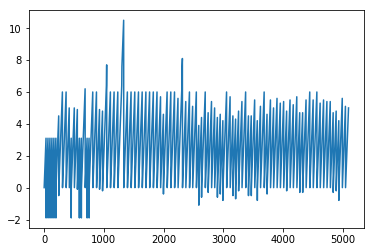

In [54]:
plt.plot([str(i) for i in all_obs])
plt.show()

In [21]:
all_obs

[0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.2,
 1.3,
 1.4000000000000001,
 1.5000000000000002,
 1.6000000000000003,
 1.7000000000000004,
 1.8000000000000005,
 1.9000000000000006,
 2.0000000000000004,
 2.1000000000000005,
 2.2000000000000006,
 2.3000000000000007,
 2.400000000000001,
 2.500000000000001,
 2.600000000000001,
 2.700000000000001,
 2.800000000000001,
 2.9000000000000012,
 3.0000000000000013,
 3.1000000000000014,
 3.2000000000000015,
 0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999,
 1.0999999999999999,
 1.2,
 1.3,
 1.4000000000000001,
 1.5000000000000002,
 1.6000000000000003,
 1.7000000000000004,
 1.8000000000000005,
 1.9000000000000006,
 2.0000000000000004,
 2.1000000000000005,
 2.2000000000000006,
 2.3000000000000007,
 2.400000000000001,
 2.500000000000001,
 2.600000000000001,
 2.700000000000001,


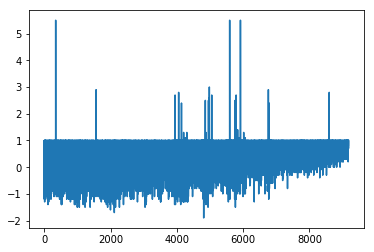

In [9]:
#50000 frames, 1500 observations, 32 batch size
scores_df = pd.read_csv(reward_file, header=None)


plt.plot(scores_df[0].values)
plt.show()



In [ ]:
#500000 frames, 500 observations, 32 batch size


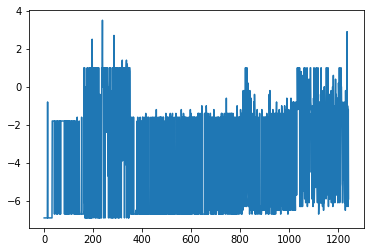

In [33]:
#50000 frames, 500 observations, 32 batch size
scores_df = pd.read_csv(reward_file, header=None)


plt.plot(scores_df[0].values)
plt.show()



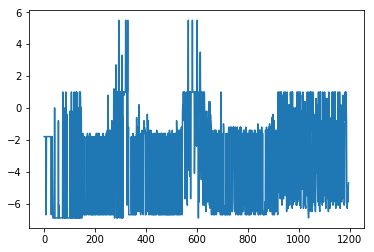

In [2]:
#50000 frames, 500 observations, 32 batch size
reward_file = 'logs/rewards_bkup'

scores_df = pd.read_csv(reward_file, header=None)


plt.plot(scores_df[0].values)
plt.show()


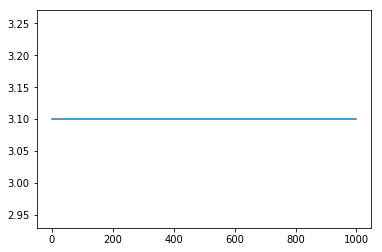

In [11]:
t_agent = PolicyAgent(input_num_rows, input_num_cols)
t_agent.load_weights('model_weights_49999')
num_games = 1000
test_scores = []
for i in range(num_games):
    output = test_agent(t_agent)
    test_scores.append(output[0])

    
    
plt.plot(test_scores)
plt.show()

In [10]:

score, images = test_agent(t_agent)
print score

3.1


In [8]:
agent._training_counter

1472

In [7]:
test_agent(agent, debug=False)

(3.1000000000000014,
  <classes.StackedImages at 0x7f6a337b4510>])

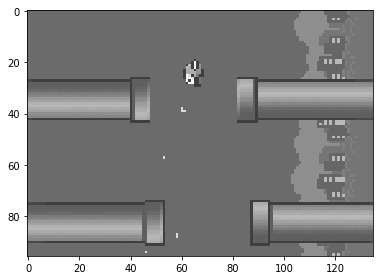

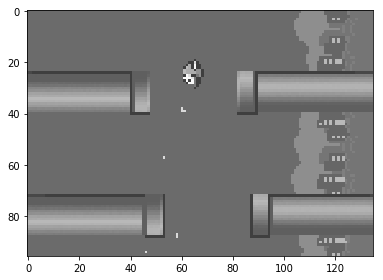

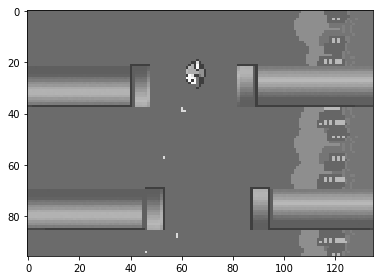

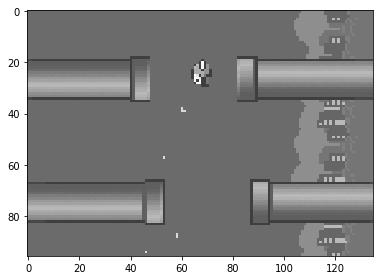

In [28]:
scored_states[1].plot()

In [29]:
agent

In [102]:
t_agent1 = PolicyAgent(input_num_rows, input_num_cols)
t_agent1.load_weights('model_weights_400000')
t_agent2 = PolicyAgent(input_num_rows, input_num_cols)
t_agent2.load_weights('model_weights_300000')
t_agent3 = PolicyAgent(input_num_rows, input_num_cols)
t_agent3.load_weights('model_weights_200000')
t_agent4 = PolicyAgent(input_num_rows, input_num_cols)
t_agent4.load_weights('model_weights_100000')


In [114]:

def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, 8, 8, subsample=(4, 4), border_mode='same',input_shape=(80,80,4)))  #80*80*4
    model.add(Activation('relu'))
    model.add(Conv2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2))
   
    adam = Adam(lr=1e-4)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

t_agent_true = buildmodel()
t_agent_true.load_weights('model.h5')

Now we build the model
We finish building the model


In [115]:
t_agent_true

In [155]:
total_rewards, all_states_post = test_agent(PolicyAgent(input_num_rows, input_num_cols), \
                                            debug=False, \
                                            display_image=False,\
                                            direction='down')


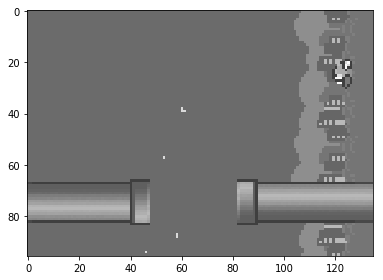

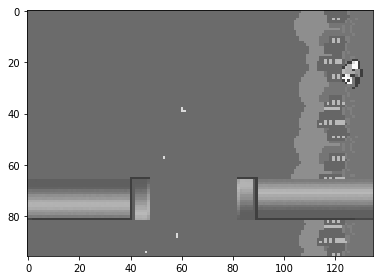

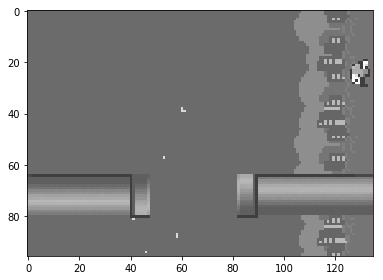

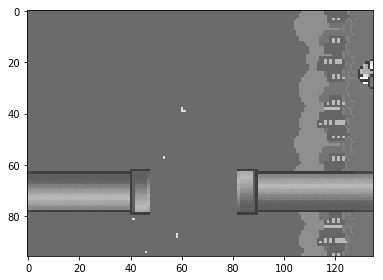

In [156]:
all_states_post[-1].plot()

In [157]:
t_agent4.predict(all_states_post[-1])

(None, array([[-0.32382098, -0.3054612 ]], dtype=float32))

In [158]:
t_agent1.predict(all_states_post[-1])

(119, array([[-0.26973468, -0.28412825]], dtype=float32))

In [134]:
io.imshow(ims[0])

TypeError: Invalid dimensions for image data

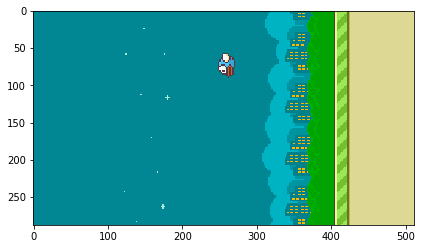

119


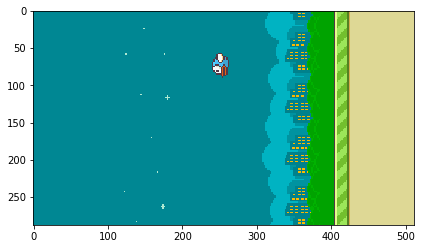

119


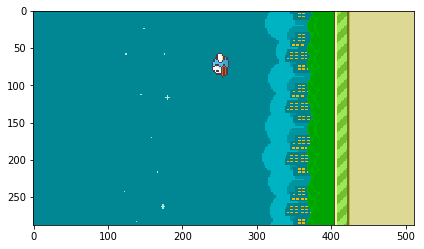

119


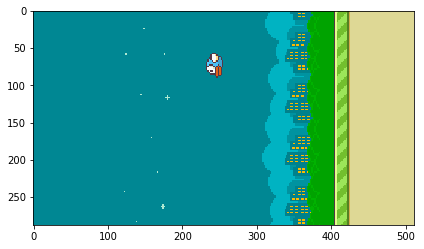

119


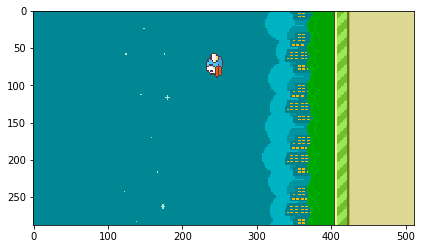

119


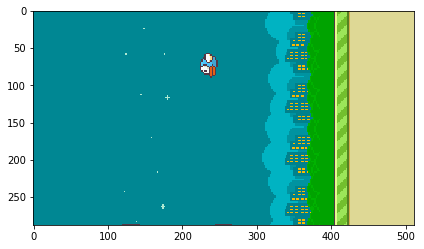

119


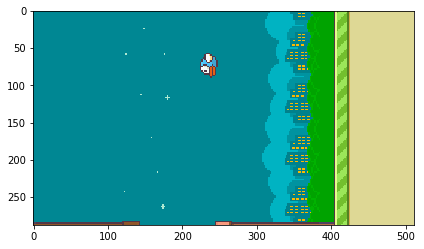

119


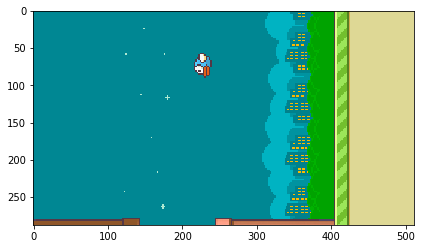

119


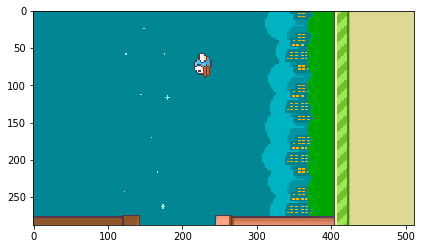

119


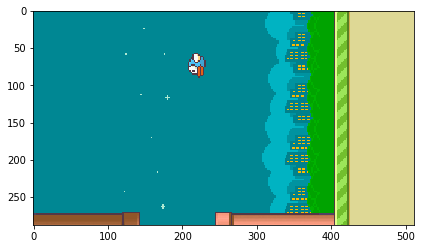

119


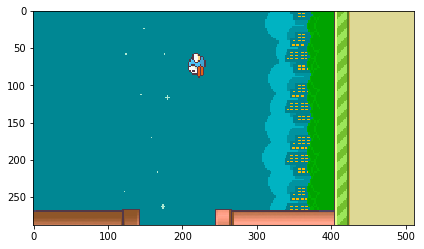

119


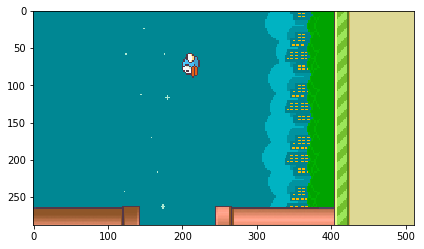

119


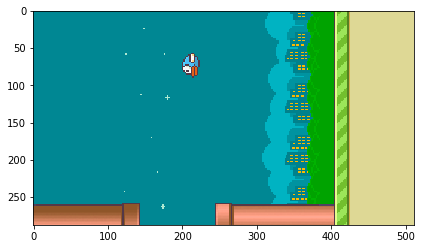

119


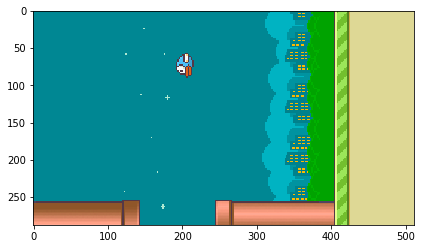

119


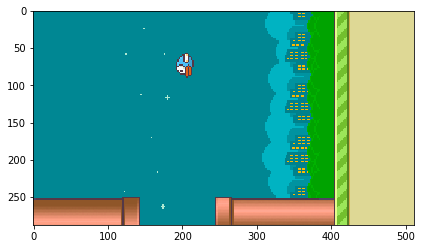

119


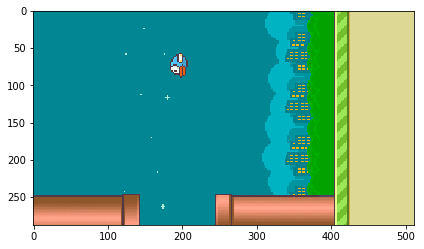

119


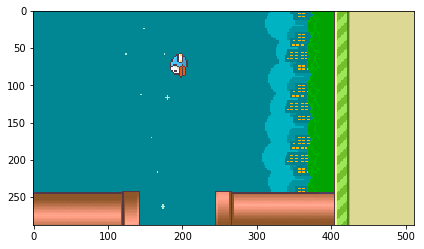

119


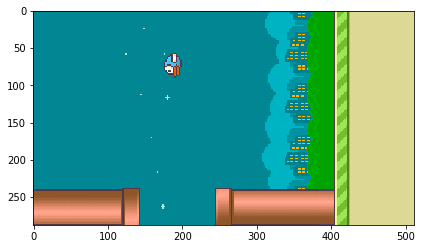

119


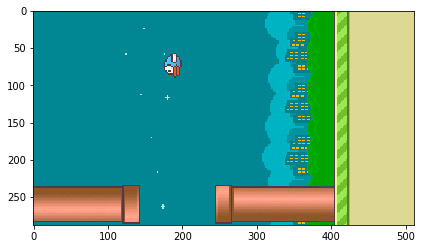

119


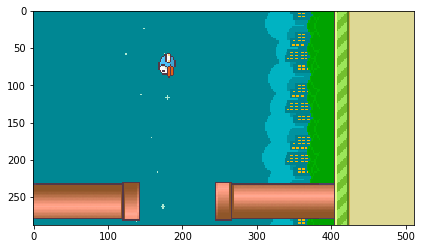

119


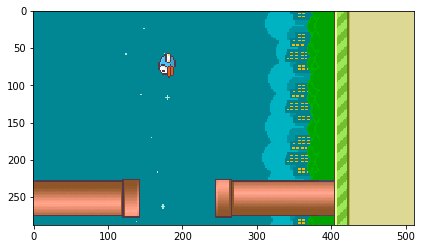

119


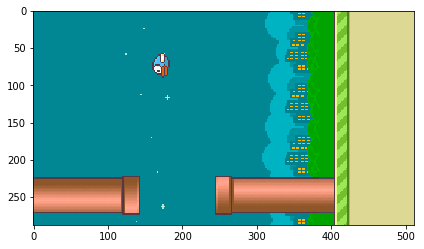

119


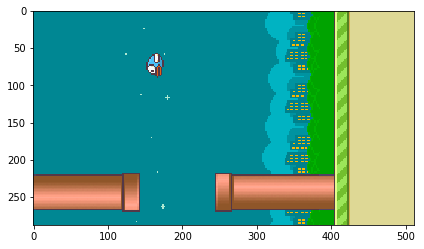

None


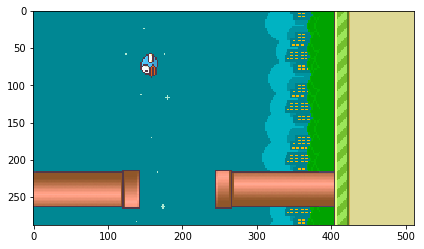

119


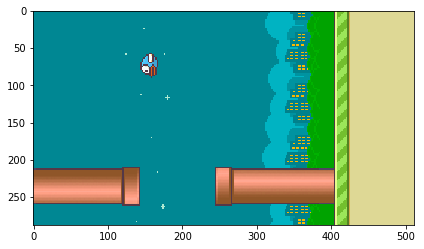

119


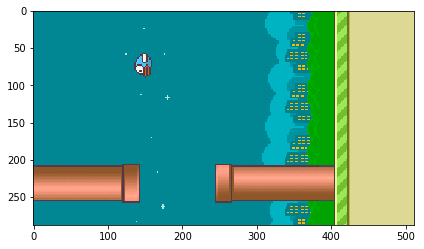

119


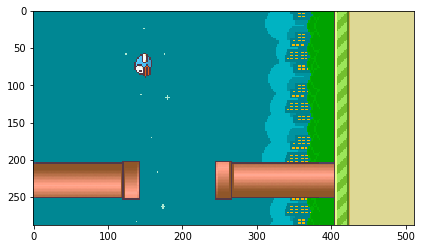

119


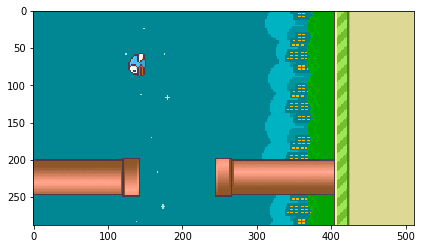

119


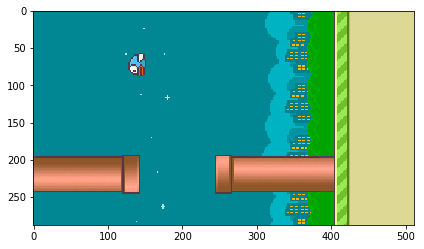

119


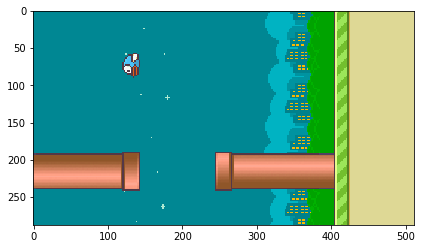

119


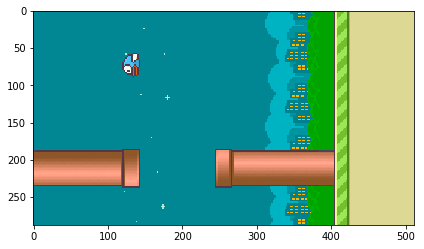

119


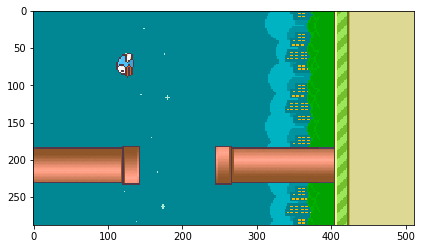

119


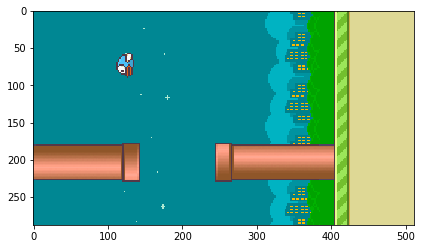

119


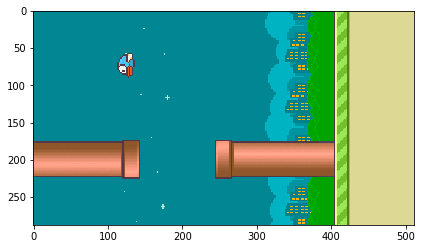

None


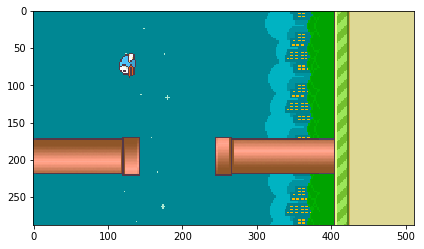

None


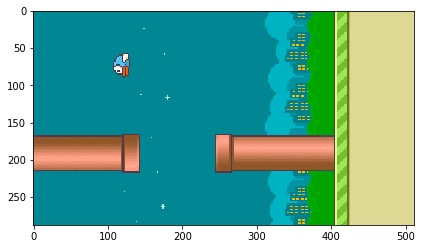

119


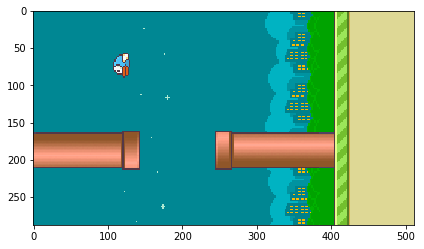

119


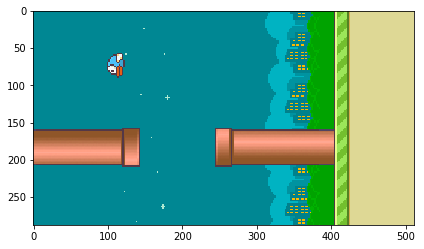

119


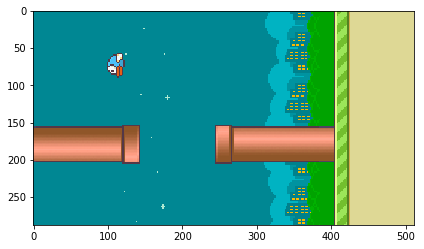

119


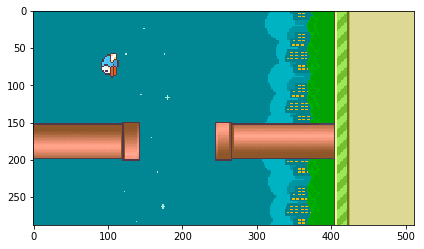

119


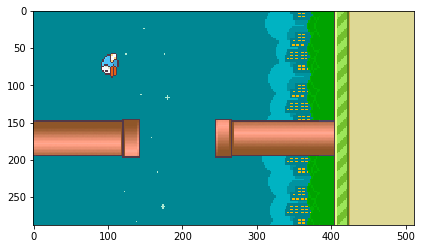

119


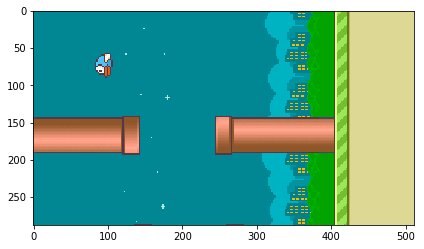

119


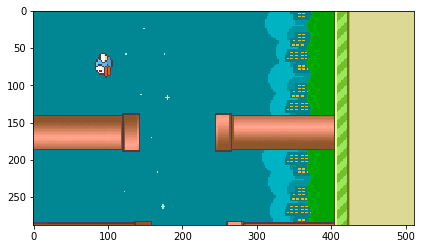

119


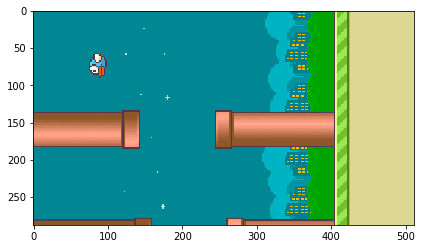

119


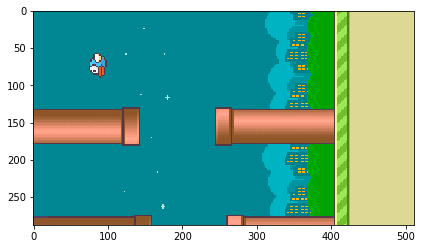

119


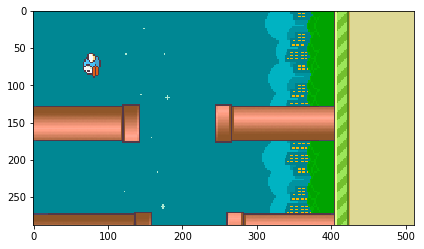

119


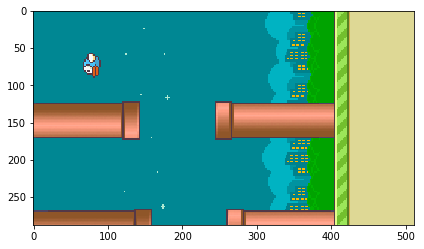

119


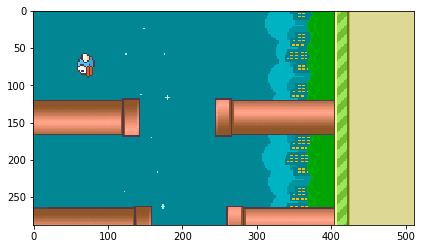

119


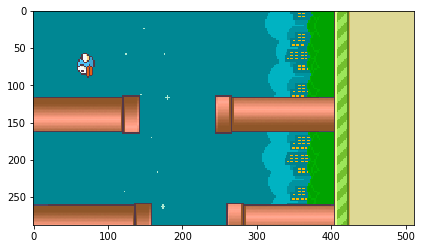

119


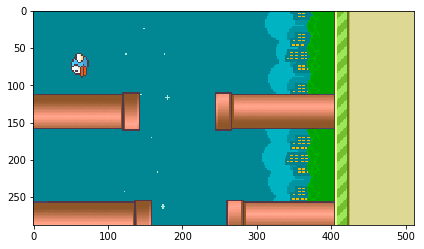

119


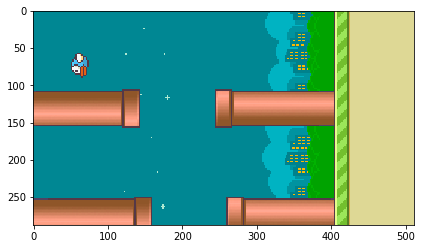

119


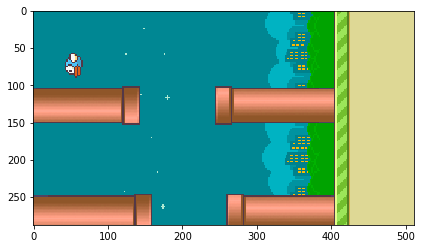

119


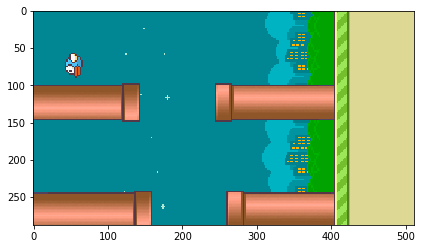

119


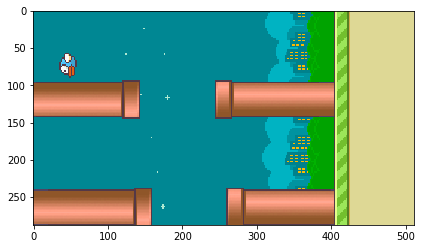

119


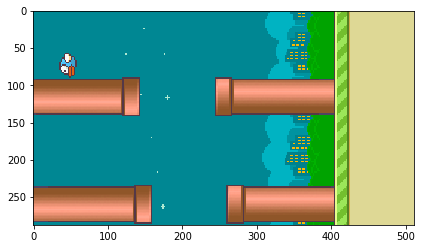

119


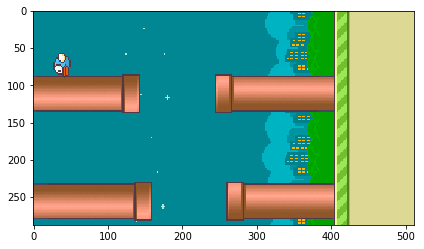

119


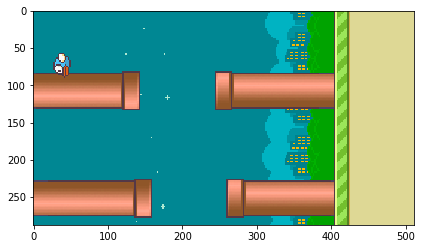

119


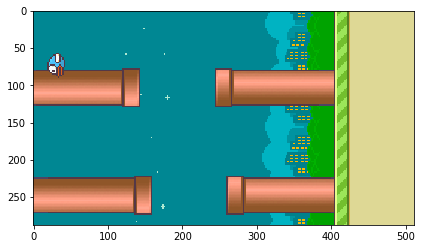

119


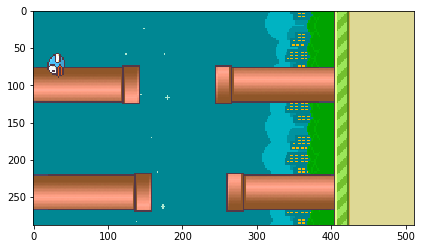

119


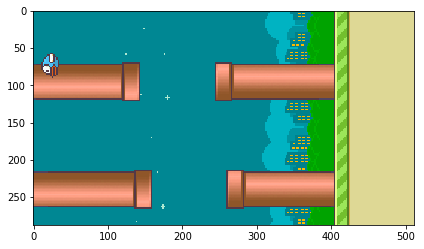

119


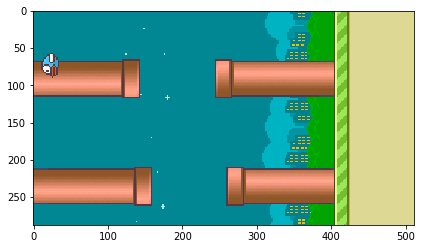

119


In [11]:
total_reward, all_states = test_agent(agent, debug=True, display_image=True)

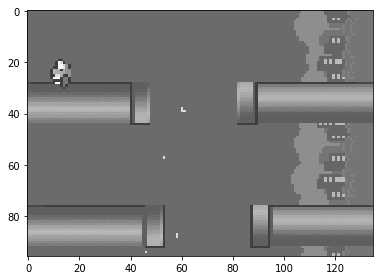

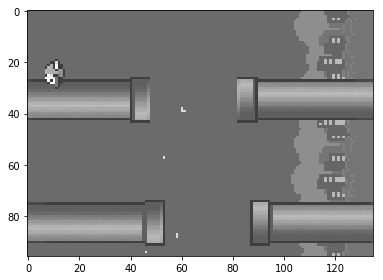

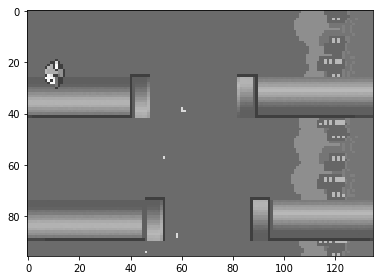

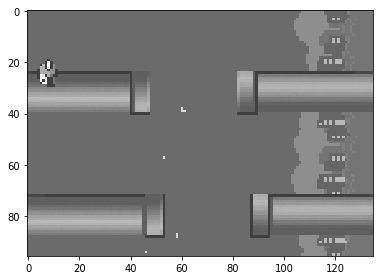

In [12]:
all_states[-1].plot()

In [13]:
#terminal at bottom of screen
#all_states_post[-1]

agent.predict(all_states_post[-1])



(119, array([[-0.36587775, -0.40195012]], dtype=float32))

In [92]:
images = all_states_post[-1].get_stacked_images()
images = images.reshape((1, 96, 135, 4))
inputs = np.zeros((1,96,135,4))
print inputs.shape

print images.shape

agent.fit(images, np.array([0,-1]).reshape(1,2))
#agent.train_on_batch(images, np.array([0,-1]).reshape(1,2))

(1, 96, 135, 4)
(1, 96, 135, 4)


In [ ]:
119 -> flap(go upwards)
None -> go downwards

In [85]:
all_states_post[-1].get_stacked_images().shape

(1, 96, 135, 4)

In [83]:
np.array([0,-1]).reshape(1,2)

array([[ 0, -1]])

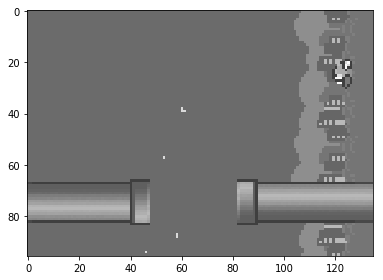

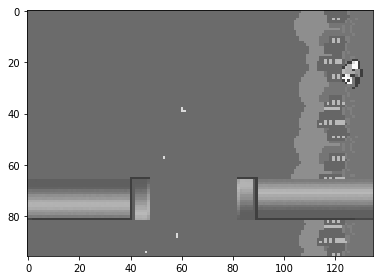

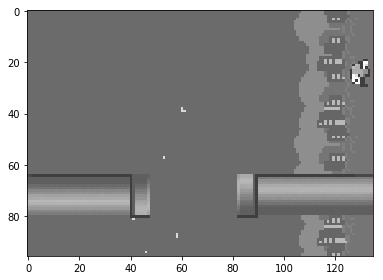

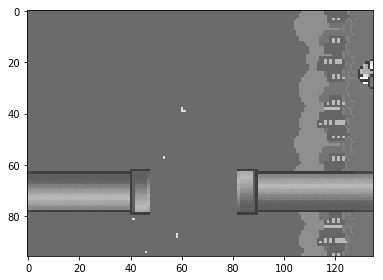

In [62]:
all_states_post[-1].plot()

In [12]:
replay_data[0][0].get_shape()

(1, 96, 135, 4)

In [22]:
replay_data[0][0].get_stacked_images()[0].shape

(96, 135)

In [44]:
replay_data[0]

 None,
 -1.0,
 True]

In [67]:
#np.split(curr_state, num_frames_to_stack, axis=0)


splits = np.split(replay_data[0][0].get_stacked_images(), 4 ,axis=0)
next_f = replay_data[0][3]

splits.append(next_f)
splits = splits[1:]
images = []
print type(split[0])
for i in range(len(splits)):
    print type(splits)

<type 'numpy.ndarray'>
<type 'list'>
<type 'list'>
<type 'list'>
<type 'list'>


In [71]:
splits = np.split(replay_data[0][0].get_stacked_images(), 4 ,axis=0)
type(replay_data[0][0].get_stacked_images())

numpy.ndarray

In [34]:
reshaped_img = img.gray_image.reshape(1, 96, 135)



array([[[ 0.42030471,  0.42030471,  0.42030471, ...,  0.4572949 ,
          0.4572949 ,  0.4572949 ],
        [ 0.42030471,  0.42030471,  0.42030471, ...,  0.4572949 ,
          0.4572949 ,  0.4572949 ],
        [ 0.42030471,  0.42030471,  0.42030471, ...,  0.4572949 ,
          0.4572949 ,  0.4572949 ],
        ..., 
        [ 0.42030471,  0.42030471,  0.42030471, ...,  0.4572949 ,
          0.4572949 ,  0.4572949 ],
        [ 0.42030471,  0.42030471,  0.42030471, ...,  0.4572949 ,
          0.4572949 ,  0.4572949 ],
        [ 0.42030471,  0.42030471,  0.42030471, ...,  0.4572949 ,
          0.4572949 ,  0.4572949 ]]])

In [78]:
p = init_game()
p.act(119)
i1 = p.getScreenRGB()

image_processors = []
for i in range(4):
    a = ImageProcessor(i1)
    image_processors.append(a)
    
image_processors[0].shape()

(96, 135)

In [88]:
stack = StackedImages(image_processors, num_per_stack=4)
stack.get_shape()

here


(1, 96, 135, 4)

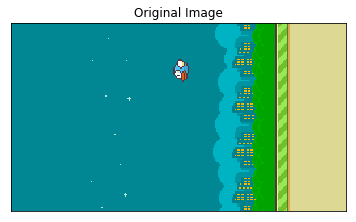

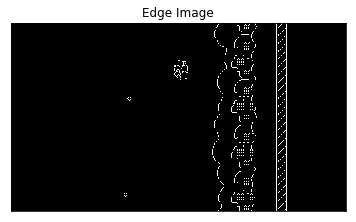

In [11]:
import cv2

p = init_game()
img = p.getScreenRGB()

edges = cv2.Canny(img,100,200)

plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()


In [7]:


p = init_game()